# Project 5

The Enron scandal of the early 2000's led to the eventual bankruptcy of a multi-billion dollar company. Enron misled shareholders and the public about their profitability and debt through a series of accounting tricks, deception, and outright fraud. The case was widely covered by news outlets, and also saw a lot of usually confidential documents make their way into the public domain: e-mails and financial data about employees. This provides a useful dataset for exploring machine learning techniques.

## Our Goal and Data Exploration

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import sys
import pickle
sys.path.append("../tools/") 

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

from sklearn.preprocessing import Imputer

from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [13]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')
df = pd.concat([df.drop('email_address', axis=1).apply(pd.to_numeric, errors='coerce'), \
                df['email_address']], axis=1) 
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,email_address
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,47.0,phillip.allen@enron.com
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,39.0,james.bannantine@enron.com
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,NaN,NaN,69.0,NaN,False,NaN,-201641.0,NaN,NaN,frank.bay@enron.com


### Question 1
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

The goal of this project is to develop a classifier which can help identify persons of interest in the Enron scandal. A person of interest is someone who was indicted, who settled without admitting guilt, or who testified in exchange for immunity. The dataset we have has information about the finances of employees, including things like salary, stock, and bonuses and about the e-mail practices of the employees, including things like how many time they sent messages to POIs. The dataset contains 146 rows, 18 of which are identified as POIs. There are 21 features in the dataset.

As for outliers, my main concern with the data was whether there were rows that would significantly skew classification. The salary information and e-mail information is presumably correct unless there was error in entering it; it is a fact of the features that there are significantly larger dollar values for some records, like Kenneth Lay's. This nature of the data could perhaps be mitigated with logarithmic scaling, but was not needed to achieve the model accuracy necessary. 

There were some rows that were odd and unhelpful for training or testing. Most obviously, the 'TOTAL' and 'THE TRAVEL AGENCY IN THE PARK' rows were unhelpful for finding POIs. However, some non-POIs in the dict were determined to also be non-helpful due to the large amount of null values they had in useful features. These included the rows for names 'LOCKHART EUGENE E', 'WODRASKA JOHN','SCRIMSHAW MATTHEW','WHALEY DAVID A','GRAMM WENDY L', and 'WROBEL BRUCE'.

In [14]:
df = df.drop(['TOTAL','THE TRAVEL AGENCY IN THE PARK'])    
df = df.drop(['LOCKHART EUGENE E','WODRASKA JOHN','SCRIMSHAW MATTHEW','WHALEY DAVID A','GRAMM WENDY L','WROBEL BRUCE'])

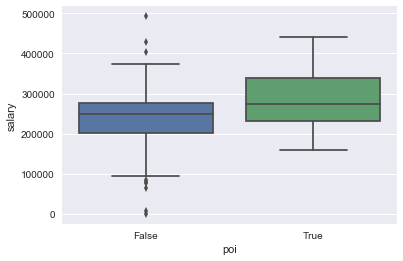

In [15]:
sns.boxplot('poi', 'salary',
           data=df[df['salary'] < df['salary'].quantile(.95)])

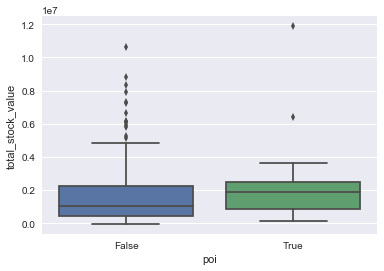

In [16]:
sns.boxplot('poi', 'total_stock_value',
           data=df[df['total_stock_value'] < df['total_stock_value'].quantile(.95)])

### Question 2
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]

The features that ended up in my model were 'exercised_stock_options', 'total_stock_value', 'bonus'. These were ultimately chosen by a loop which averaged the results of SelectKBest over many folds of StratifiedShuffleSplit after paring down the feature list according to whether there was enough useful data; those columns that had a lot of missing values were eliminated. An extreme case was 'loan_advances' which had data for only 3 people but 'director_fees', 'restricted_stock_deferred', 'deferral_payments', and 'deferred_income' were dropped for the same reason. Additionally, 'other' and 'email_address' were dropped, the former for being too non-descriptive and the latter because it wouldn't work with my choice in classifiers. 

In [17]:
drop_columns = ['other', 'email_address', 'director_fees', 'loan_advances', 
                'restricted_stock_deferred', 'deferral_payments', 'deferred_income']
df = df.drop(drop_columns, axis=1)

In [18]:
my_dataset = df.to_dict(orient='index')
features_list = [u'poi', u'salary', u'to_messages', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'total_stock_value', u'expenses',
       u'from_messages', u'from_this_person_to_poi',
       u'long_term_incentive', u'from_poi_to_this_person']
scores_dict = dict.fromkeys(features_list[1:], np.array([]))       
def mean_selector_score(dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    imp = Imputer(strategy='median')
    features = imp.fit_transform(features)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    selector = SelectKBest(k='all')
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        selector.fit(features_train, labels_train)
        for score, feature in zip(selector.scores_, features_list[1:]):
            scores_dict[feature] = np.append(scores_dict[feature], score)
mean_selector_score(my_dataset, features_list)
scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df.mean().sort_values(ascending=False)

exercised_stock_options    23.406684
total_stock_value          20.073231
bonus                      13.673070
salary                      9.442976
long_term_incentive         7.519849
restricted_stock            7.302580
total_payments              6.996585
shared_receipt_with_poi     6.286249
from_poi_to_this_person     3.678794
from_this_person_to_poi     2.025036
expenses                    0.929172
to_messages                 0.791943
from_messages               0.227710
dtype: float64

In [19]:
features_list = [u'poi', u'exercised_stock_options', u'total_stock_value', u'bonus']

No scaling was necessary since both attempted classifiers would not be affected by this. 

A feature that was engineered was the percentage of messages sent to POIs and received from POIs. The thought was maybe the overall percentage would be more predictive than a raw number since some people naturally send more e-mails than others, but if someone had larger percentages of correspondence of POIs, that might be worth looking at. The new feature 'sent_to_poi_pct' did end up being picked by SelectKBest, but resulted in almost exactly the same values in my evaluation metrics with SelectKBest(k=6). These were not included in the final classifier since I could get the same accuracy with fewer features.

In [20]:
df['sent_to_poi_pct'] = df['from_this_person_to_poi'] / df['from_messages']
df['received_from_poi_pct'] = df['from_poi_to_this_person'] / df['to_messages']

A problem for classifying was the amount of null values, so an imputer was used in the final pipeline to fill NAs with the median of the column. Median was chosen as its a better fit for the wild variance seen in some of the financial data. 

### Question 3
What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

The final algorithm settled on was Gaussian Naive Bayes, GaussianNB(), in a pipeline with an Imputer filling null values with medians for that column. 

Note about Imputer as part of pipeline: Optimally the dataset would have medians for the entire dataset and not only the current training set. To refactor my_dataset to the proper dictionary form with median values proved very difficult. However, it was easy to alter test_classifier to fill median values before the StratifiedShuffleSplit and this achieved comparable (actually better) accuracy overall. 

I also tried scikit's logistic regression with built in cross validation, LogisticRegressionCV(). Both classifier algorithms performed better in precision than in recall. However, the LogisticRegressionCV algorithm resulted in significantly longer training and testing time, probably due to the cross validation it performed. 

### Question 4
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]

Tuning the parameters of the algorithm is to set the particular values in the initialization of the algorithm to values which optimize it for the problem at hand. This is a tricky process, and if performed incorrectly it can lead to problems like overfitting on the training set, or the exact opposite and do poorly on the training set. Since I was using GaussianNB, the only parameter on my classifier that I had to tune was the priors. I also experimented with the number of features included, adding new ones to test in order of highest score to lowest. I wrote a loop to test the accuracy of the classifier given a variety of values for priors and then looked through a resulting dataframe to figure out the best prior as well as the best set of features. I settled on priors of [.15, .85] and the aforementioned features.

In [21]:
%%capture
features_list_score_order = [u'exercised_stock_options', u'total_stock_value', u'bonus', u'salary',
       u'long_term_incentive', u'restricted_stock', u'total_payments',
       u'shared_receipt_with_poi', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'expenses', u'to_messages',
       u'from_messages']
testing_features_list = [u'poi']
acc = []
prec = []
reca = []
acc_all = []
prec_all = []
reca_all = []
results_dict = {}
def tuneNB():
    for i in range(1, 20):
        acc = []
        prec = []
        reca = []
        testing_features_list = [u'poi']
        for feature in features_list_score_order:
            testing_features_list.append(feature)
            pipe = Pipeline([('impute', Imputer(strategy='median')), 
                    ('classify', GaussianNB(priors=[(i/2.)*.1, (1 - (i/2.)*.1)]))])
            total_predictions, accuracy, precision, recall, f1, f2 = \
                test_classifier(pipe, my_dataset, testing_features_list, folds=100)
            acc.append(accuracy)
            prec.append(precision)
            reca.append(recall)
        acc_all.append(acc)
        prec_all.append(prec)
        reca_all.append(reca)
        results_dict['prec' + str(i)] = prec
        results_dict['reca' + str(i)] = reca
        results_dict['acc' + str(i)] = acc
tuneNB()

In [22]:
test_df = pd.DataFrame(results_dict)

drop_me = []
for i in range(1,10):
    if (pd.concat([(test_df['prec' + str(i)] > .38),
       (test_df['reca' + str(i)] > .42),
       (test_df['acc' + str(i)] > .82)], axis=1).sum(axis=1) == 3).sum() == 0:
        drop_me.extend(['prec' + str(i), 'reca' + str(i), 'acc' + str(i)])
test_df = test_df.drop(drop_me, axis=1)
test_df

,acc10,acc11,acc12,acc13,acc14,acc15,acc16,acc17,acc18,acc19,...,reca12,reca13,reca14,reca15,reca16,reca17,reca18,reca19,reca2,reca3
0,0.855714,0.856429,0.857857,0.857143,0.858571,0.859286,0.862143,0.862857,0.865714,0.866429,...,0.265,0.260,0.255,0.255,0.255,0.255,0.255,0.230,1.000,0.615
1,0.848571,0.847857,0.847143,0.847857,0.848571,0.848571,0.848571,0.849286,0.852143,0.857857,...,0.255,0.255,0.255,0.255,0.255,0.255,0.255,0.255,0.320,0.320
2,0.843571,0.843571,0.845000,0.846429,0.846429,0.848571,0.849286,0.851429,0.856429,0.865714,...,0.325,0.325,0.325,0.325,0.325,0.325,0.325,0.325,0.430,0.425
3,0.832143,0.832143,0.832857,0.833571,0.837857,0.840714,0.849286,0.857857,0.865000,0.870000,...,0.325,0.325,0.325,0.325,0.325,0.325,0.325,0.320,0.385,0.355
4,0.830000,0.832143,0.833571,0.836429,0.838571,0.845000,0.848571,0.852143,0.857143,0.863571,...,0.350,0.350,0.350,0.345,0.330,0.330,0.320,0.310,0.475,0.455
5,0.839286,0.841429,0.843571,0.845000,0.847857,0.850714,0.850714,0.851429,0.853571,0.854286,...,0.345,0.335,0.330,0.330,0.325,0.325,0.325,0.300,0.420,0.380
6,0.838571,0.838571,0.840000,0.840000,0.839286,0.838571,0.837857,0.837857,0.840000,0.840000,...,0.275,0.270,0.265,0.260,0.255,0.240,0.225,0.205,0.310,0.295
7,0.822143,0.822143,0.822857,0.822143,0.822143,0.822857,0.823571,0.828571,0.832143,0.834286,...,0.205,0.200,0.200,0.190,0.190,0.190,0.190,0.185,0.255,0.240
8,0.822143,0.822143,0.822857,0.822143,0.822143,0.823571,0.823571,0.828571,0.832143,0.833571,...,0.205,0.200,0.200,0.195,0.190,0.190,0.190,0.185,0.260,0.240
9,0.822143,0.822857,0.822143,0.822143,0.822143,0.821429,0.823571,0.825714,0.831429,0.835000,...,0.200,0.200,0.200,0.190,0.190,0.190,0.190,0.190,0.250,0.230


In [23]:
pipe = Pipeline([('impute', Imputer(strategy='median')),
        ('classify', GaussianNB(priors=[.15, .85]))])

### Question 5
What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]

Validation is the process by which data is set aside or used so as to make sure a model performs well on data it hasn't seen yet. If this isn't handled well, we can end up overfitting the training data. This would leave us with a model that didn't generalize well or handle cases it had not yet seen. A mistake that can be made is letting too much knowledge of your test set leak into parameters used for the training set. In this case, we end up overfitting to the test set, even though it's not even part of our training data. 

My final method for validating my analysis was by using the provided test_classifier function, which uses Stratified Shuffle Split with a large number of folds. Some preliminary testing was also performed by a simple train/test set split.

### Question 6
Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

In [24]:
total_predictions, accuracy, precision, recall, f1, f2 = \
    test_classifier(pipe, my_dataset, features_list, folds=1000)

Pipeline(steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('classify', GaussianNB(priors=[0.15, 0.85]))])
	Accuracy: 0.82393	Precision: 0.39503	Recall: 0.43750	F1: 0.41518	F2: 0.42829
	Total predictions: 14000	True positives:  875	False positives: 1340	False negatives: 1125	True negatives: 10660



The algorithm's overall accuracy is 82.39%. This sounds respectable, but it does score lower than the accuracy of a naive algorithm which only assigned False to every row's POI. This would end up with an accuracy of about 88% in the current dataset. However, this would also end up with a 0 in two other measures that our used algorithms scores much better in: precision and recall.

Precision is the number of correctly identified POIs divided by the sum of correct POIs and falsely identified POIs. This is a measure of how often the algorithm "got it right" when it thought someone was a POI. So about 39.5% of the time that the algorithm thinks a person is a POI, it's actually right that they are. A respectable performance given the few features needed to get there, but it's certainly not good enough to determine whether someone should be charged with a crime or not.

On the other hand, recall is the number of correctly identified POIs divided by the sum of correct POIs and POIs that were missed. This is a measure of how often the algorithm missed identifying a POI it was looking at. At about 43.75% of the time when given a POI, the algorithm realized it was in fact a POI. Again, a respectable performance, but not one good enough to automatically assume someone is innocent if the algorithm said they were.